# IDAT1 - Test Pattern Generator
Based on lab two of Adam Taylors Pynq-Z2 tutorial series for Element14  
https://github.com/ATaylorCEngFIET/Element14_PYNQ

In [12]:
import time
from pynq.overlays.tpd_pynq import tpd_pynqOverlay
import numpy as np
from pynq import pl
from pynq import overlay
from pynq.lib.video import *
from pynq import Xlnk
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

#### Program FPGA

In [13]:
overlay = tpd_pynqOverlay('IDAT1_Test_Pattern_Generator.bit')

The following attributes are available on this overlay:  

    axi_intc_0           : pynq.overlay.DefaultIP  
    axi_vdma_0           : pynq.lib.video.dma.AxiVDMA  
    color_convert_0      : pynq.lib.video.pipeline.ColorConverter  
    pixel_pack_0         : pynq.lib.video.pipeline.PixelPacker  
    v_tpg_0              : pynq.overlay.DefaultIP  
    processing_system7_0 : pynq.overlay.DefaultIP  

#### Pixel Pack
Set pixel pack to expect 24-bit RGB pixels from test pattern generator.  
It will package these as 32-bit.

In [14]:
pixel_in = overlay.pixel_pack_0
pixel_in.bits_per_pixel = 24

#### Colour Converter
Set colour converter to invert colourspace from RGB to BGR. 

In [15]:
colourspace_in = overlay.color_convert_0
rgb2bgr = [0.0, 1.0, 0.0,
           1.0, 0.0, 0.0,
           0.0, 0.0, 1.0,
           0.0, 0.0, 0.0]

colourspace_in.colorspace = rgb2bgr

#### VDMA
Set VDMA attributes so it knows what kind of video to expect.  
These should match the test pattern generator attributes in the next step.

In [16]:
cam_vdma = overlay.axi_vdma_0
lines = 512
framemode = VideoMode(640, lines, 24)
cam_vdma.readchannel.mode = framemode
cam_vdma.readchannel.start()

#### Test Pattern Generator
Set a handful of properties including height, width and pattern by writing directly to registers.  
You can find a reference of the exact registers in the product description.

In [17]:
tpg = overlay.v_tpg_0
tpg.write(0x10,512) # height
tpg.write(0x18,640) # width
tpg.write(0x40,0)
tpg.write(0x30,0)
tpg.write(0x20,0xB) # pattern
tpg.write(0x00,0x81)

#### Test 1
Pull a frame from the VDMA and display.

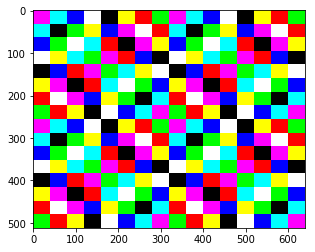

In [18]:
frame_camera = cam_vdma.readchannel.readframe()
frame_color = cv2.cvtColor(frame_camera,cv2.COLOR_BGR2RGB)
pixels = np.array(frame_color)
plt.imshow(pixels)
plt.show()

#### Test 2
Vary the pattern value and pull a frame from the VDMA for each.  
Display the results in a grid.

In [23]:
patterns = []

for i in range(16):

    tpg.write(0x20,i)
    
    frame_camera = cam_vdma.readchannel.readframe()
    frame_color=cv2.cvtColor(frame_camera,cv2.COLOR_BGR2RGB)
    pixels = np.array(frame_color)
    
    patterns.append(pixels)

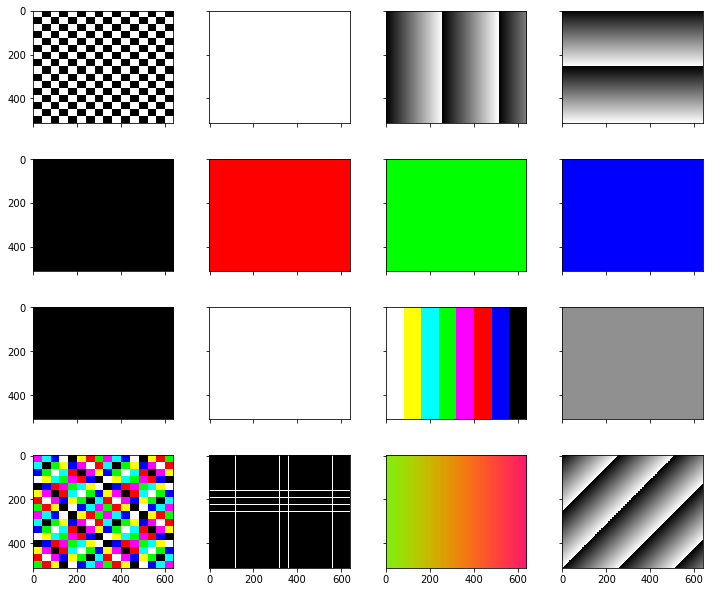

In [24]:
fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.5)

for ax, pattern in zip(grid,patterns):
    ax.imshow(pattern)

plt.show()

#### Stop VDMA

In [10]:
cam_vdma.readchannel.stop()